# Importing libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, validation_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import metrics
import itertools


# 1. Reading the data#
## Data obtained from https://data.seattle.gov/Land-Base/Collisions/9kas-rb8d##

In [2]:
df=pd.read_csv('Collisions_03102020.csv')
print(df.shape)

(221525, 40)


D:\Anaconda3\envs\TGPU\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (35) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.describe(include="all")

,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
count,2.140500e+05,214050.000000,221525.000000,221525.000000,221525.000000,221525,221525,217813,71936.000000,216935,...,195103,194933,5195,1.272050e+05,9929,212112,195212,221525.000000,2.215250e+05,221525
unique,NaN,NaN,NaN,NaN,NaN,221522,2,3,NaN,25202,...,9,9,1,NaN,1,112,62,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,1780512,Matched,Block,NaN,BATTERY ST TUNNEL NB BETWEEN ALASKAN WY VI NB ...,...,Dry,Daylight,Y,NaN,Y,32,One parked--one moving,NaN,NaN,N
freq,NaN,NaN,NaN,NaN,NaN,2,195285,144999,NaN,298,...,128588,119492,5195,NaN,9929,41353,44931,NaN,NaN,209492
mean,1.271147e+06,229822.714977,110763.000000,144824.873233,145053.886627,NaN,NaN,NaN,37626.275537,NaN,...,NaN,NaN,NaN,7.971063e+06,NaN,NaN,NaN,261.135903,9.577244e+03,NaN
std,7.361903e+03,20463.229585,63948.903529,89222.567072,89598.173976,NaN,NaN,NaN,51968.207339,NaN,...,NaN,NaN,NaN,2.611523e+06,NaN,NaN,NaN,3246.962907,7.146156e+04,NaN
min,1.249026e+06,184059.089009,1.000000,1001.000000,1001.000000,NaN,NaN,NaN,23807.000000,NaN,...,NaN,NaN,NaN,1.007024e+06,NaN,NaN,NaN,0.000000,0.000000e+00,NaN
25%,1.266677e+06,214145.383695,55382.000000,71668.000000,71668.000000,NaN,NaN,NaN,28653.000000,NaN,...,NaN,NaN,NaN,6.007029e+06,NaN,NaN,NaN,0.000000,0.000000e+00,NaN
50%,1.271142e+06,228336.487966,110763.000000,127252.000000,127252.000000,NaN,NaN,NaN,29973.000000,NaN,...,NaN,NaN,NaN,8.033011e+06,NaN,NaN,NaN,0.000000,0.000000e+00,NaN
75%,1.276029e+06,245908.853680,166144.000000,209935.000000,210155.000000,NaN,NaN,NaN,33984.000000,NaN,...,NaN,NaN,NaN,1.018101e+07,NaN,NaN,NaN,0.000000,0.000000e+00,NaN


# 3. Data understanding

# 3.1 Data Cleaning and removing empty values for exploring 

In [4]:
df.drop(["INCKEY","COLDETKEY"],axis=1,inplace=True)

import seaborn as sns

D:\Anaconda3\envs\TGPU\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


UNDERINFL - shows whether or not a driver involved was under the influence of drugs or alcohol. It contains Y and 1, or N and 0 let's apply function to dataset to uniform

In [5]:
df["UNDERINFL"].unique()

array(['N', '0', nan, 'Y', '1'], dtype=object)

In [6]:
def for_UNDERINFL(x):
    if x in ['Y','1']:
        return "Y"
    elif x in ['N','0']:
        return "N"
    else:
        return x
    
df["UNDERINFL"] = df["UNDERINFL"].apply(for_UNDERINFL)

Also, column SEVERITYCODE has nan values it better to analyze and move to corresponded category if applicalbe.

In [7]:
df["SEVERITYCODE"].fillna('0', inplace=True)

In [8]:
df["ADDRTYPE"].fillna('Not Mentioned', inplace=True)

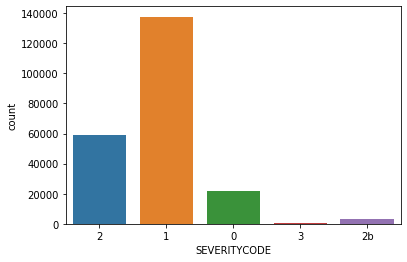

In [9]:
sns.countplot(df["SEVERITYCODE"])

The same data but in percentage 

In [10]:
df["SEVERITYCODE"].value_counts(normalize=True).round(2)

1     0.62
2     0.27
0     0.10
2b    0.01
3     0.00
Name: SEVERITYCODE, dtype: float64

Most accidents around 62% of accidents is "Property Damage Only Collision"(Category 1).
26% belong to "Injury Collision"(Category 2). other categories weight is less than 11 percent

# 3.2 Accidents trend by Month and Year

"Date of accindent" should be converted to appropriate format that could be feed to pandas so let us use astype to convert INCDATE and create to adiitonal columns to see information by month and year

In [11]:
df["INCDATE"]=pd.to_datetime(df["INCDATE"])
df["MONTH"] = df["INCDATE"].dt.month
df["YEAR"] = df["INCDATE"].dt.year

In [12]:
MONTH=["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"]
DA=df.groupby(["YEAR","MONTH"])[["INCDATE"]].count()
RDA=DA.unstack().values
DA_C=pd.DataFrame(RDA,columns=MONTH,index=np.arange(2003,2021))
DA_C.fillna(0,inplace=True)
DA_C

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
2003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2004,1197.0,1060.0,1218.0,1254.0,1320.0,1287.0,1275.0,1361.0,1262.0,1443.0,1336.0,1444.0
2005,1192.0,1080.0,1333.0,1349.0,1395.0,1372.0,1396.0,1346.0,1304.0,1447.0,1417.0,1385.0
2006,1434.0,1232.0,1229.0,1307.0,1276.0,1327.0,1281.0,1318.0,1285.0,1356.0,1519.0,1230.0
2007,1325.0,1036.0,1275.0,1140.0,1297.0,1331.0,1304.0,1266.0,1244.0,1398.0,1270.0,1196.0
2008,1207.0,1024.0,1182.0,1193.0,1187.0,1153.0,1134.0,1259.0,1153.0,1302.0,1203.0,1142.0
2009,984.0,882.0,1059.0,1067.0,1283.0,1192.0,1205.0,1092.0,1082.0,1299.0,1128.0,1002.0
2010,998.0,950.0,944.0,902.0,977.0,1003.0,1026.0,1055.0,966.0,1176.0,1037.0,924.0
2011,1022.0,860.0,1075.0,1030.0,1051.0,1127.0,1029.0,1007.0,1060.0,1070.0,1059.0,1026.0
2012,936.0,880.0,1061.0,1042.0,1107.0,1033.0,1035.0,1137.0,1038.0,1258.0,1088.0,1117.0


It can be seen that there is only one accident is recorded however in documentation, it is said that all data is from 2004 till present.
for graph we will eliminate 2003 as it is possible incorrectly entered information.

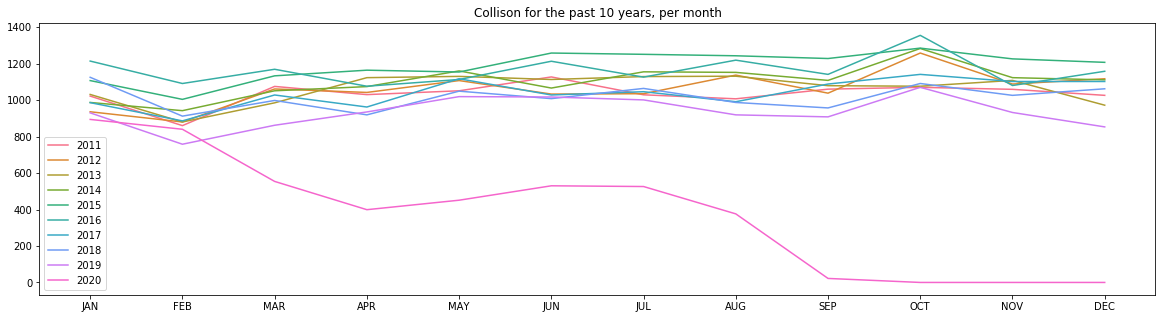

In [13]:
import matplotlib.pyplot as plt
sns.set_palette(sns.color_palette("rocket_r"))
plt.figure(figsize=(20,5))
plt.title("Collison for the past 10 years, per month")
sns.lineplot(data=DA_C[-10:].T,dashes=False,sort=False)

You can observe that number of accidents are steadily decreasing over the years without taking into account 2020 as COVID 19 quarantine locked population in their homes. For example 2019, number of colissions per month is below for previous years.

# 3.3 Accident by Time of the day

D:\Anaconda3\envs\TGPU\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


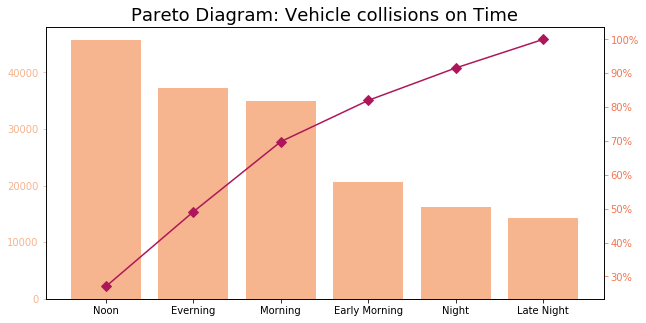

In [14]:
import matplotlib

df["INCTIME"] = pd.to_datetime(df["INCDTTM"])
for idx, dt in enumerate(df["INCDTTM"]):
    if ':' not in dt:
        df["INCTIME"][idx] = np.nan

b = [0,4,8,12,16,20,24]
l = ['Late Night', 'Early Morning','Morning','Noon', 'Everning','Night']
df["TIMEOFDAY"] = pd.cut(df["INCTIME"].dt.hour, bins=b, labels=l, include_lowest=True)

df_TOD = pd.DataFrame(df['OBJECTID'].groupby(df['TIMEOFDAY'].astype('object')).count())
df_TOD = df_TOD.sort_values(by='OBJECTID',ascending=False)
df_TOD["cumpercentage"] = df_TOD["OBJECTID"].cumsum()/df_TOD["OBJECTID"].sum()*100

fig, ax = plt.subplots(figsize=(10,5))
ax2 = ax.twinx()
ax.bar(df_TOD.index, df_TOD["OBJECTID"])
ax2.plot(df_TOD.index, df_TOD["cumpercentage"], color="C9", marker="D", ms=7)
ax2.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter())

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")

plt.title("Pareto Diagram: Vehicle collisions on Time", fontsize=18)

plt.show()

D:\Anaconda3\envs\TGPU\lib\site-packages\pandas\plotting\_matplotlib\__init__.py:61: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002EF3F3FD550>,
      dtype=object)

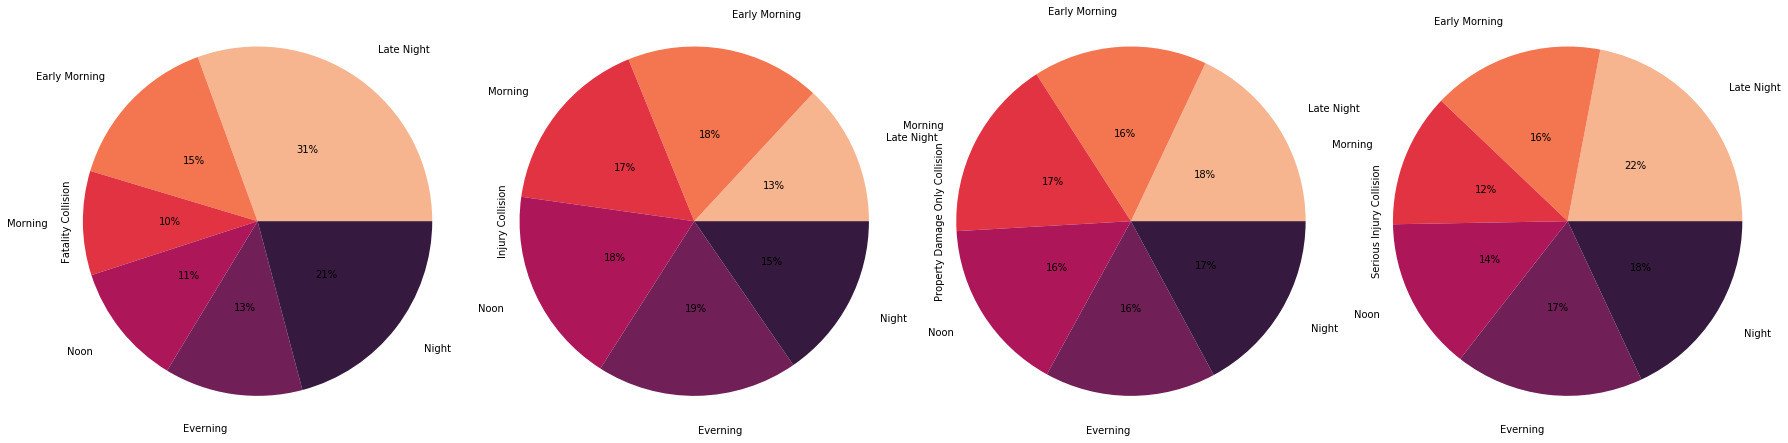

In [15]:
fig, ax = plt.subplots(figsize=(30,20))
df_temp = df.copy()
df_temp = df_temp[df_temp["SEVERITYCODE"]!='0']
(pd.crosstab(df_temp.TIMEOFDAY, df_temp.SEVERITYDESC).apply(lambda r: r/r.sum(), axis=1)*100).plot.pie(subplots=True, ax=ax, autopct='%1.0f%%', pctdistance=0.5,labeldistance=1.2, radius=1.2, legend=None)

# 3.4 Mapping incidents

In [29]:
import folium
latitude =47.6225
longitude =-122.3520

df_M=df[['X', 'Y']]
df_M.dropna(inplace=True)

D:\Anaconda3\envs\TGPU\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [30]:
# create map and display it
seattle_map = folium.Map(location=[latitude, longitude], zoom_start=12)


In [31]:
from folium import plugins

# let's start again with a clean copy of the map of San Francisco
seattle_map = folium.Map(location = [latitude, longitude], zoom_start = 12)

# instantiate a mark cluster object for the incidents in the dataframe
incidents = plugins.MarkerCluster().add_to(seattle_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng in zip(df_M.Y[:1000], df_M.X[:1000]):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=None,
    ).add_to(incidents)

# display map
seattle_map

# 4. Data Cleaning

#### This dataset too consist of a lot of missing values and useless datas .so before further processing the data it is important to clean the dataset¶

#### The following features(columns) should be drop as they have a lot of missing values and not usefull or irrelevant for predicting severity: STATUS, INTKEY,OBJECTID, INCKEY, COLDETKEY, REPORTNO, EXCEPTRSNCODE, EXCEPTRSNDESC, INCDATE, INATTENTIONIND, PEDROWNOTGRNT, SDOTCOLNUM, SEGLANEKEY, CROSSWALKKEY 


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221525 entries, 0 to 221524
Data columns (total 42 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   X                214050 non-null  float64            
 1   Y                214050 non-null  float64            
 2   OBJECTID         221525 non-null  int64              
 3   REPORTNO         221525 non-null  object             
 4   STATUS           221525 non-null  object             
 5   ADDRTYPE         221525 non-null  object             
 6   INTKEY           71936 non-null   float64            
 7   LOCATION         216935 non-null  object             
 8   EXCEPTRSNCODE    101122 non-null  object             
 9   EXCEPTRSNDESC    11779 non-null   object             
 10  SEVERITYCODE     221525 non-null  object             
 11  SEVERITYDESC     221525 non-null  object             
 12  COLLISIONTYPE    195212 non-null  object             
 13 

>Selecting usfull futures for the dataset

In [33]:
Features=['X', 'Y', 'LOCATION', 'SEVERITYCODE',  'SEVERITYDESC', 'COLLISIONTYPE',
 'PERSONCOUNT', 'PEDCOUNT','PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE','ADDRTYPE',
 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC','UNDERINFL', 'SPEEDING',
 'WEATHER','ROADCOND', 'LIGHTCOND',  'ST_COLCODE', 'ST_COLDESC', 'HITPARKEDCAR',
 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES','TIMEOFDAY']

df = df[Features]


>Checking the null records in the dataset. It can be seen half of sample has missing values.

In [34]:
df.isnull().sum()

X                    7475
Y                    7475
LOCATION             4590
SEVERITYCODE            0
SEVERITYDESC            0
COLLISIONTYPE       26313
PERSONCOUNT             0
PEDCOUNT                0
PEDCYLCOUNT             0
VEHCOUNT                0
INCDATE                 0
ADDRTYPE                0
JUNCTIONTYPE        11974
SDOT_COLCODE            1
SDOT_COLDESC            1
UNDERINFL           26293
SPEEDING           211596
WEATHER             26503
ROADCOND            26422
LIGHTCOND           26592
ST_COLCODE           9413
ST_COLDESC          26313
HITPARKEDCAR            0
INJURIES                0
SERIOUSINJURIES         0
FATALITIES              0
TIMEOFDAY           52369
dtype: int64

To fill missing values for features - ***LOCATION, JUNCTIONTYPE,COLLISIONTYPE, ST_COLCODE, ST_COLDESC***, would be difficult as has ***enormous kind of values***. However, LOCATION and ADDRTYPE could be indentified by Lonlitute and Latitude but it requires significant amount of time an, moreover, this feature will be considered any way by Lonlitute and Latitude.For other features, we could accept most ***logical value*** or assign to "Unknown", if applicable. For instance, missing values of*** SPEEDING, WEATHER,ROADCOND, LIGHTCOND could be replaced*** by 

In [57]:
Features_upd=['X', 'Y', 'PERSONCOUNT', 'PEDCOUNT','PEDCYLCOUNT', 'VEHCOUNT',
'UNDERINFL', 'SPEEDING', 'WEATHER','ROADCOND', 'LIGHTCOND',
'HITPARKEDCAR','INJURIES', 'SERIOUSINJURIES', 'FATALITIES','TIMEOFDAY']

df_upd = df[Features_upd]

In [58]:
df_upd['SPEEDING'].fillna('N',inplace=True)
df_upd['WEATHER'].fillna('Unknown',inplace=True)
df_upd['LIGHTCOND'].fillna('Unknown',inplace=True)
df_upd['ROADCOND'].fillna('Dry',inplace=True)
df_upd['UNDERINFL'].fillna('N',inplace=True)

# this our target value and it has various amount of fatatlity 
#but it should binary so we are replacing all value above to 1(fatal)
df_upd['FATALITIES'] = np.where(df_upd['FATALITIES'] > 0, 1,0)

# conduct check of missing values in our dataset
df_upd.isnull().sum()

D:\Anaconda3\envs\TGPU\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


X                   7475
Y                   7475
PERSONCOUNT            0
PEDCOUNT               0
PEDCYLCOUNT            0
VEHCOUNT               0
UNDERINFL              0
SPEEDING               0
WEATHER                0
ROADCOND               0
LIGHTCOND              0
HITPARKEDCAR           0
INJURIES               0
SERIOUSINJURIES        0
FATALITIES             0
TIMEOFDAY          52369
dtype: int64

In [59]:
# Longitude and latitude cann't be replaced so only solution is to drop the missing values
df_upd.dropna(subset=['X','Y','TIMEOFDAY'], inplace=True)

D:\Anaconda3\envs\TGPU\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Converting categorical features which are indicated below object in Dtype into one hot encoding by use built function of pandas like pd.dummies

In [60]:
df_upd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 164663 entries, 0 to 221523
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   X                164663 non-null  float64 
 1   Y                164663 non-null  float64 
 2   PERSONCOUNT      164663 non-null  int64   
 3   PEDCOUNT         164663 non-null  int64   
 4   PEDCYLCOUNT      164663 non-null  int64   
 5   VEHCOUNT         164663 non-null  int64   
 6   UNDERINFL        164663 non-null  object  
 7   SPEEDING         164663 non-null  object  
 8   WEATHER          164663 non-null  object  
 9   ROADCOND         164663 non-null  object  
 10  LIGHTCOND        164663 non-null  object  
 11  HITPARKEDCAR     164663 non-null  object  
 12  INJURIES         164663 non-null  int64   
 13  SERIOUSINJURIES  164663 non-null  int64   
 14  FATALITIES       164663 non-null  int32   
 15  TIMEOFDAY        164663 non-null  category
dtypes: category(1), floa

In [62]:
dff = pd.concat([df_upd.drop(['WEATHER', 'ROADCOND', 'LIGHTCOND',
                'UNDERINFL','SPEEDING','HITPARKEDCAR','TIMEOFDAY'], axis=1),
                 pd.get_dummies(df_upd['WEATHER'],prefix='Weather'),
                 pd.get_dummies(df_upd['ROADCOND'],prefix='ROADCOND'),
                 pd.get_dummies(df_upd['LIGHTCOND'],prefix='LIGHTCOND'),
                 pd.get_dummies(df_upd['UNDERINFL'],prefix='UNDERINFL'),
                 pd.get_dummies(df_upd['SPEEDING'],prefix='SPEEDING'),
                 pd.get_dummies(df_upd['TIMEOFDAY'],prefix='TOD'),
                pd.get_dummies(df_upd['HITPARKEDCAR'],prefix='HITPARKED')], axis=1)
dff.reset_index(drop=True, inplace=True)

# Modelling and Evaluation

#### The process of modeling means training a machine learning algorithm to predict the labels from the features, tuning it for the business need, and validating it on holdout data.The output from modeling is a trained model that can be used for inference, making predictions on new data points.
#### Model Evaluation is an integral part of the model development process. It helps to find the best model that represents our data and how well the chosen model will work in the future. To avoid overfitting, both methods use a test set (not seen by the model) to evaluate model performance

#### Due to type of output is expect (Fatality - Yes/No), classification model should be applied. there is a lot of different classifiers - Logistic regression, Decision tree, and so on. I will test all of them to find a model showing the best accuracy on both test and train.

## Splitting the dataset into Train and test samples
In previous section, it was obvious that from data exploring, most collisions happens at Night so avoid baised dataset stratified sampling based on TIMEOFDAY will be applied to split data into train and test. 20% of all samples moves for testing at final stage and rest is used for training the model.

In [63]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164663 entries, 0 to 164662
Data columns (total 51 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   X                                   164663 non-null  float64
 1   Y                                   164663 non-null  float64
 2   PERSONCOUNT                         164663 non-null  int64  
 3   PEDCOUNT                            164663 non-null  int64  
 4   PEDCYLCOUNT                         164663 non-null  int64  
 5   VEHCOUNT                            164663 non-null  int64  
 6   INJURIES                            164663 non-null  int64  
 7   SERIOUSINJURIES                     164663 non-null  int64  
 8   FATALITIES                          164663 non-null  int32  
 9   Weather_Blowing Sand/Dirt           164663 non-null  uint8  
 10  Weather_Blowing Snow                164663 non-null  uint8  
 11  Weather_Clear             

In [65]:
from sklearn.model_selection import train_test_split

X=dff.drop(['FATALITIES'],axis=1)
y=dff['FATALITIES']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Decision tree classifier

In [67]:
tree_model = DecisionTreeClassifier(criterion='entropy', max_depth=5)
tree_model.fit(X_train, y_train)
print(tree_model)
yhat1 = tree_model.predict(X_test)
print('The accuracy of the decision tree classifier is {} with a max_depth of 5'.format(accuracy_score(y_test, yhat1)))

DecisionTreeClassifier(criterion='entropy', max_depth=5)
The accuracy of the decision tree classifier is 0.9979959311329062 with a max_depth of 5


In [69]:
print(classification_report(y_test, yhat1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     32868
           1       0.47      0.14      0.21        65

    accuracy                           1.00     32933
   macro avg       0.74      0.57      0.61     32933
weighted avg       1.00      1.00      1.00     32933



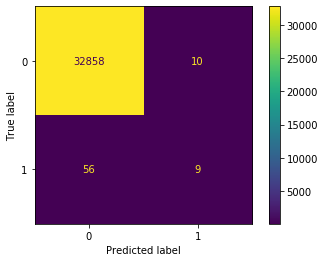

In [70]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(tree_model,X_test,y_test)
plt.show()

### Random Forest

In [71]:
forest_model = RandomForestClassifier(n_estimators=75)
forest_model.fit(X_train, y_train)
print(forest_model)
yhat2 = forest_model.predict(X_test)
print('the accuracy score for Random Forest Classifier is {}'.format(accuracy_score(y_test, yhat2)))

RandomForestClassifier(n_estimators=75)
the accuracy score for Random Forest Classifier is 0.9979959311329062


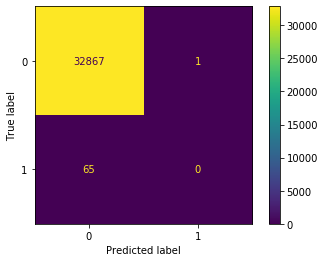

In [72]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(forest_model,X_test,y_test)
plt.show()

### Logistic regression

In [73]:
log_reg_model = LogisticRegression(C=0.06)
log_reg_model.fit(X_train, y_train)
print(log_reg_model)
yhat3 = log_reg_model.predict(X_test)
print('The accuracy score for logistic regression is {}'.format(accuracy_score(y_test, yhat3)))

LogisticRegression(C=0.06)
The accuracy score for logistic regression is 0.9980262958127106


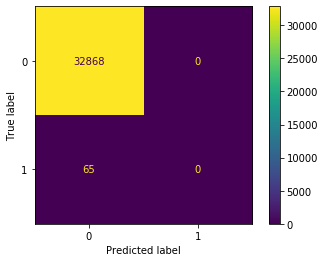

In [75]:
plot_confusion_matrix(log_reg_model,X_test,y_test)
plt.show()

### Result

The accuracies of all the models is around 99.8% which means we can accurately predict the fatality of an accident. 

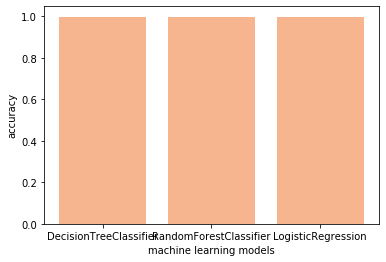

In [76]:
plt.bar(['DecisionTreeClassifier', 'RandomForestClassifier', 'LogisticRegression'], [0.9979,0.9979,0.998])
plt.ylabel('accuracy')
plt.xlabel('machine learning models')
plt.show()

### **Conclusion**

#### The accuracy of the classifiers is great and all models almost show  100%. However, the Decision tree classifier shows less  FalseTrue than other models. In our case, False True means that it predicted incorrecty that there is no fatality however there was 56 fatal incidents. Despite this fact, overall, the model has trained well and fits the training data and performs well on the testing set as well as the training set. We can conclude that this model can accurately predict the Fatality of car accidents in Seattle.